Files already downloaded and verified
Files already downloaded and verified
50000 10000


(<PIL.Image.Image image mode=RGB size=32x32 at 0x112E8D160>, 3)

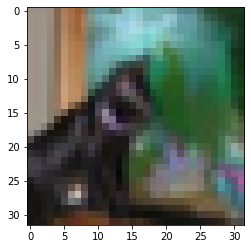

In [6]:
from torchvision import datasets

#dir(datasets)
dataset_train = datasets.CIFAR10('.', train = True, download = True) #download = True --> if not already in the path, then does
dataset_val = datasets.CIFAR10('.', train = False, download = True) #train=False --> validation!

print(len(dataset_train), len(dataset_val))

from matplotlib import pyplot as plt
img, label = dataset_train.__getitem__(159)
plt.imshow(img)
img, label

torch.Size([3, 32, 32])
torch.Size([3, 32, 32]) torch.float32


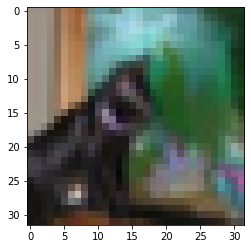

In [8]:
from torchvision import transforms

#dir(transforms)
to_tensor = transforms.ToTensor() # changes np arrays and PIL images to tensors
img_t = to_tensor(img)
print(img_t.shape)

#transform all items in dataset to tensors
dataset_train_t = datasets.CIFAR10('.', train = True, download = False, 
                                   transform = transforms.ToTensor())

dataset_val_t = datasets.CIFAR10('.', train = False, download = False, 
                                   transform = transforms.ToTensor())

img_t, label = dataset_train_t[159]
print(img_t.shape, img_t.dtype) # type: float in range 0. to 1.
img_t

#show the image from tensor form
plt.imshow(img_t.permute(1,2,0)) #ToTrensor() changes dims from H*W*C to C*H*W, so needed to rechange it to original form

torch.Size([3, 32, 32, 50000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


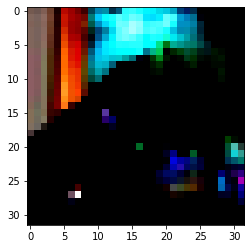

In [9]:
#normalizing...

import torch

#stack up all img_t's in a tensor and compute mean and stdev across each channel
imgs = torch.stack([img_t for img_t, _ in dataset_train_t], dim=3) #dim=3: 50000 appears as the 3rd dim
print(imgs.shape)
imgs.view(3,-1).shape #keeps the 3 channels (1st dim) and merges the rest: 32*32*50000
means = imgs.view(3,-1).mean(dim=1) #mean over 2nd dim (of size 32*32*50000)
[m1, m2, m3] = means.numpy()
stdevs = imgs.view(3,-1).std(dim=1)
[s1, s2, s3] = stdevs.numpy()

#init normalizer
transforms.Normalize((m1,m2,m3), (s1,s2,s3))

dataset_train_transformed = datasets.CIFAR10('.', train = True, download = False,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((m1,m2,m3), (s1,s2,s3))
                                            ]))
dataset_val_transformed = datasets.CIFAR10('.', train = False, download = False,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((m1,m2,m3), (s1,s2,s3))
                                            ]))

img_t, _ = dataset_train_transformed[159]
plt.imshow(img_t.permute(1,2,0)) #after normalization the showed image has deteriorated 

#checking the result of normalization:
#torch.stack([img_t for img_t, _ in dataset_train_transformed],dim=3).view(3,-1).mean(dim=1) #roughly (0.,0.,0.)
#torch.stack([img_t for img_t, _ in dataset_train_transformed],dim=3).view(3,-1).std(dim=1) # (1,1,1)

In [11]:
# toward a binary classifier: prep data
#manually extract relevant train and validation data
label_map = {0:0, 2:1} #in the main dataset airplane and bird have indexes 0 and 2 resp.
class_names = ['airplane','bird']
dataset_train_2 = [(img, label_map[label]) 
                    for (img, label) in dataset_train_transformed 
                       if label in [0,2]]
dataset_val_2 = [(img, label_map[label]) 
                    for (img, label) in dataset_val_transformed 
                       if label in [0,2]]
#img, _ = dataset_val_2[100]
#plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3443, grad_fn=<NllLossBackward>)

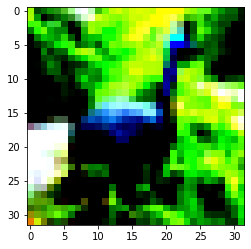

In [28]:
#nn for the image classifier...

import torch.nn as nn

n_classes = 2
model = nn.Sequential(nn.Linear(3072, 512), #3*32*32 input features, 512 hidden output features
                     nn.Tanh(),
                     nn.Linear(512,n_classes))

#softmax: from (a tensor of) numbers to (a tensor of) probablities
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

softmax(torch.tensor([1.,2.,3.]))

x = torch.tensor([[1.,2.,3.],[1.,2.,3.]])
sftm = nn.Softmax(dim=1) #apply softmax along dim 1
sftm(x)

#model with softmax
model = nn.Sequential(nn.Linear(3072, 512), 
                     nn.Tanh(),
                     nn.Linear(512,n_classes),
                     nn.Softmax(dim=1))

img,label = dataset_train_2[0]
plt.imshow(img.permute(1,2,0))

img = img.view(-1).unsqueeze(0) #make it linear (of 3*32*32 = 3072 size) and add a 2nd dim as dim 0: 1 * 3072
out = model(img)
#print(out)
torch.max(out, dim=1) #compute max along dim 1, returns pair of probability and index where max value is


#loss function: need to maximize likelihood: out[c_i], i.e., the probability where c_i is the index of correct class
#negative log likelihood (NLL): sum(log(out[c_i])) does the job!
#To use NLL, change Softmax to LogSoftmax (to compute log of probability), since NLL doesn't compute log.
model = nn.Sequential(nn.Linear(3072, 512), 
                     nn.Tanh(),
                     nn.Linear(512,n_classes),
                     nn.LogSoftmax(dim=1))
out = model(img)
loss = nn.NLLLoss()
loss(out, torch.tensor([label])) #result of LogSoft and correct label passed

In [30]:
import torch.optim as optim

def training_loop(n_epochs, loss_fn, model, optimizer, dataset_train):
    for epoch in range(1 + n_epochs):
        for img, label in dataset_train:
            img = img.view(-1).unsqueeze(0)
            out = model(img) # out: of size [n_classes]
            loss = loss_fn(out, torch.tensor([label]))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("epoch: %d, loss: %f" %(epoch, loss)) #loss of the last img in dataset is reported


In [87]:
#create a collection of batches from the dataset, size of each batch: 64
# 156 batches of size 64, and 1 batch of size 16 (remaining): 156 * 64 + 16 = 10000 (img, lbl) pair in dataset_train_2
train_loader = torch.utils.data.DataLoader(dataset_train_2, batch_size=64, shuffle=True)
#print(len(train_loader))
#print([(imgs.shape, lbls.shape) for imgs, lbls in train_loader][0])

# 31 batches of size 64, and 1 batch of size 16: 31 * 64 + 16 = 2000 (img, lbl) pair in dataset_val_2
val_loader = torch.utils.data.DataLoader(dataset_val_2, batch_size=64, shuffle = True)
#print(len(val_loader))
#print([(imgs.shape, lbls.shape)for imgs,lbls in val_loader])

def training_loop_2(n_epochs, loss_fn, model, optimizer, dataset_train, train_loader, val_loader):
    total = 0 # total number of labels at the end of training
    correct = 0 # total num of correctly predicated labels at the end of training
    for epoch in range(1 + n_epochs):
        for imgs, labels in train_loader: # a random batch is selected
            batch_size = imgs.shape[0]
            outs = model(imgs.view(batch_size, -1)) # outs: batch_size * n_classes
            loss = loss_fn(outs, labels) # since loss is NLL, it doesn't say much about the correct class prediction
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            (max_vals, max_classes) = torch.max(outs, dim=1) #max_vals: batch_size log of likelihoods (return of LogSoftmax)
                                                             #max_classes: batch_size indexes of classes with max value: 0 or 1
            total += labels.shape[0] # accumulate batch_size's: total number of labels 
            correct += int((labels == max_classes).sum()) # accumulate number of matching labels
        print("epoch: %d, loss: %f" %(epoch, loss)) # loss of the random batch is reported
    print("training accuracy: %f", correct/total)
        
    #model is trained. next, validation...
    total = 0 # total number of labels at the end of validation
    correct = 0 # total num of correctly predicated labels at the end of validation
    with torch.no_grad(): 
        for imgs, labels in val_loader: # a random batch is selected
            batch_size = imgs.shape[0]
            outs = model(imgs.view(batch_size, -1)) # outs: batch_size * n_classes, where each value is log of likelihoods (return of LogSoftmax)
            (max_vals, max_classes) = torch.max(outs, dim=1) #max_vals: batch_size log of likelihoods (return of LogSoftmax)
                                                             #max_classes: batch_size indexes of classes with max value: 0 or 1
            total += labels.shape[0] # accumulate batch_size's: total number of labels 
            correct += int((labels == max_classes).sum()) # accumulate number of matching labels
        print('validation accuracy: %f', correct/total)
            

In [89]:
training_loop_2(n_epochs = 20, 
              loss_fn = nn.NLLLoss(),
              model = model,
              optimizer = optim.SGD(model.parameters(), lr = 1e-2),
              dataset_train = dataset_train_2,
              train_loader = train_loader,
               val_loader = val_loader)

epoch: 0, loss: 0.000568
epoch: 1, loss: 0.000607
epoch: 2, loss: 0.001025
epoch: 3, loss: 0.001512
epoch: 4, loss: 0.000661
epoch: 5, loss: 0.000719
epoch: 6, loss: 0.000783
epoch: 7, loss: 0.000620
epoch: 8, loss: 0.000974
epoch: 9, loss: 0.000330
epoch: 10, loss: 0.000671
epoch: 11, loss: 0.000597
epoch: 12, loss: 0.001070
epoch: 13, loss: 0.000574
epoch: 14, loss: 0.000460
epoch: 15, loss: 0.000973
epoch: 16, loss: 0.000309
epoch: 17, loss: 0.000715
epoch: 18, loss: 0.000515
epoch: 19, loss: 0.001443
epoch: 20, loss: 0.000487
training accuracy: %f 1.0
validation accuracy: %f 0.8135


In [90]:
model_bigger = nn.Sequential(nn.Linear(3072,1024),
                            nn.Tanh(),
                            nn.Linear(1024,512),
                            nn.Tanh(),
                            nn.Linear(512,128),
                            nn.Tanh(),
                            nn.Linear(128,n_classes),
                            nn.LogSoftmax(dim=1))

training_loop_2(n_epochs = 20, 
              loss_fn = nn.NLLLoss(),
              model = model_bigger,
              optimizer = optim.SGD(model.parameters(), lr = 1e-2),
              dataset_train = dataset_train_2,
              train_loader = train_loader,
               val_loader = val_loader)

epoch: 0, loss: 0.711525
epoch: 1, loss: 0.714973
epoch: 2, loss: 0.728065
epoch: 3, loss: 0.694856
epoch: 4, loss: 0.670121
epoch: 5, loss: 0.696836
epoch: 6, loss: 0.711036
epoch: 7, loss: 0.690928
epoch: 8, loss: 0.693678
epoch: 9, loss: 0.694272
epoch: 10, loss: 0.687413
epoch: 11, loss: 0.702576
epoch: 12, loss: 0.692382
epoch: 13, loss: 0.671009
epoch: 14, loss: 0.665843
epoch: 15, loss: 0.696044
epoch: 16, loss: 0.672010
epoch: 17, loss: 0.680198
epoch: 18, loss: 0.680352
epoch: 19, loss: 0.706911
epoch: 20, loss: 0.699197
training accuracy: %f 0.5023
validation accuracy: %f 0.5025
